In [80]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_rows",1300)
pd.set_option("display.max_columns",12000)
pd.set_option('display.max_rows',200000)
pd.set_option('display.width', 320)
team_info = pd.read_csv('data/team_info.csv')
nhl = pd.read_csv('data/nhl_sorted_by_dates.csv')
odds = pd.read_csv('data/odds_all_years.csv')
odds = odds[::2]
nhl2 = nhl.copy()
string = '2018-09-30'
class Season():
    def __init__(self, df, date='0'):
        self.nhl = df
        self.date = date
        df2 = nhl.copy()
        self.s = df2
        self.df_last = df2[-1:] # get last row of data frame
        self.end_reg_season={'2011': 13, '2012': 11, '2013': 30, '2014': 16, '2015': 15, '2016': 13, '2017': 12, '2018': 11, '2019': 10}
        arr = str(self.df_last.date_time).split('-') # get date of last row of df and split to get year
        _ = arr[0].split(" ") # turn series object into something useable
        year = _[-1]
        self.final_year = int(year)
    def last_reg_date(self,reg=0):    #finish to include playoffs
        # split out just the year from date given to class
        splt = self.date.split('-')
        year = int(splt[0])
        month = splt[1]
        if month >='01' and month <='04':
            return str(year)+'-04-'+str(self.end_reg_season.get(str(year))-1)
        if year >= self.final_year:                                 # if year is the end of the data frame return the last date available
            return self.df_last.date_time                           #does not work!!!!!!!!!!!!!!
        else:                                                       # else the year is older than the last year in the df return the end of the season date
            new_year=str(year+1)
            next = new_year+'-04-'+str(self.end_reg_season.get(str(new_year))-1)
            return next
    def get_team_ids(self):
        df = self.nhl
        season = df[(df['date_time'] > self.date) & (df['date_time'] < self.last_reg_date())]
        ids = season.home_team_id.unique()
        return ids
    def season_team(self,team_id,stop='0'):
        df = self.nhl
        if stop=='0':
            season = df[(df['date_time'] > self.date) & (df['date_time'] < self.last_reg_date())]
            season = season[(season['home_team_id']==team_id) | (season['away_team_id']==team_id)]
            self.s = season
            return season
        else:
            season = df[(df['date_time'] > self.date) & (df['date_time'] < stop)]
            season = season[(season['home_team_id'] == team_id) | (season['away_team_id'] == team_id)]
            self.s = season
            return season
    def win_lose(self, away_team, home_team, away_goals, home_goals, team_id):
        if team_id != away_team and team_id != home_team:
            return "error"
        if (away_team == team_id and away_goals > home_goals) or (home_team == team_id and home_goals > away_goals):
            return 'w'
        else:
            return 'l'
    def create_win_column(self,team_id):
        df = self.s
        df['win_loss'] = df.apply(lambda col: self.win_lose(int(col[4]), int(col[5]), int(col[6]), int(col[7]), int(team_id)), axis=1)
        return df
    def team_streak(self,df_form=0):
        lst = self.s.win_loss.tolist()
        ws = [0]
        for i in lst:
            if i == 'w':
                if ws[-1] > 0:
                    ws.append(ws[-1] + 1)
                else:
                    ws.append(1)
            elif i == 'l' and ws[-1] > 0:
                ws.append(-1)
            else:
                ws.append(ws[-1] - 1)
        ws.remove(ws[0])
        if df_form==0:
            return ws
        else:
            self.s['streak'] = ws
            return self.s
    def get_points(dic):
        team_points = {}
        for i in dic:
            lst = dic.get(i)
            points = []
            for j in range(len(lst)):
                if j == 0:
                    if lst[j]>0:
                        points.append(2)
                    else:
                        points.append(0)
                else:
                    if lst[j]>0:
                        points.append(points[j-1]+2)
                    else:
                        points.append(points[j-1])
            team_points.update({i:points})
        return team_points

if __name__ == '__main__':

    del nhl['date_time_GMT']
    del nhl['home_rink_side_start']
    del nhl['venue_link']
    del nhl['venue_time_zone_id']
    yr = '2010'
    start = '-09-30'

    # create teams dictionary --either of season or streak ...
    def data_form(df,yr,start,stop_yr=2019,default=1,tm_id=0,df_or_dict=0):
        tms = {}
        nhl = df
        yr1 = int(yr)
        if default != 0:
            for i in range(stop_yr-yr1):
                season = Season(nhl,(yr + start))
                end = season.end_reg_season.get(str(int(yr)+1))
                for j in season.get_team_ids():
                    dt = str(int(yr)+1)+'-04-'+str(end)
                    season.season_team(j, stop=dt)
                    season.create_win_column(j)
                    name = team_info[(team_info['team_id']==j)].abbreviation.max()
                    if df_or_dict == 0:
                        tms.update({name +'-'+ yr :season.team_streak()})
                    else:
                        tms.update({name +'-'+ yr :season.team_streak(df_form=1)})
                yr = str(int(yr)+1)
        else:
            season = Season(nhl, (yr + start))
            for i in range(stop_yr-yr1):
                end = season.end_reg_season.get(str(int(yr) + 1))
                dt = str(int(yr) + 1) + '-04-' + str(end)
                season.season_team(team)
                season.create_win_column(tm_)
                name = team_info[(team_info['team_id'] == j)].abbreviation.max()
                if df_or_dict == 0:
                    tms.update({name + '-' + yr: season.team_streak()})
                else:
                    tms.update({name + '-' + yr: season.team_streak(df_form=1)})
                yr = str(int(yr) + 1)
        return tms


    def win_streak_per_team_per_season(dct,st,tm_pts,opp_pts):
        overall = []
        st=int(st)
        opp_points_per_team_per_season = {}
        w=int()
        if st>0:
            w=1
        else:
            w=0
        if w ==1:
    #  ******* winning streaks ********
            winstreaks_per_team_per_season = {}
            for i in dct:
                lst = []
                tm_opps = []
                strk = dct.get(i)
                tm = tm_pts.get(i)
                op = opp_pts.get(i)
                for j in range(len(strk)):
                    if j != len(strk)-1:
                        if strk[j] >= st and strk[j+1]!=strk[j]+1:
                            lst.append(strk[j])
                            overall.append(strk[j])
                            tm_opps.append([tm[j+1],op[j+1],strk[j]])
                    else:
                        if strk[j]>= st and strk[j-1]==strk[j]-1:
                            lst.append(strk[j])
                            overall.append(strk[j])
                winstreaks_per_team_per_season.update({i:lst})
                opp_points_per_team_per_season.update({i:tm_opps})
            return winstreaks_per_team_per_season,opp_points_per_team_per_season, overall
        else:
    # ******* losing streaks ********
            losingstreaks_per_team_per_season = {}
            for i in dct:
                lst = []
                tm_opps = []
                strk = dct.get(i)
                op = opp_pts.get(i)
                tm = tm_pts.get(i)
                for j in range(len(strk)):
                    if j != len(strk)-1:
                        if strk[j] <= st and strk[j+1]!=strk[j]-1:
                            lst.append(strk[j])
                            overall.append(strk[j])
                            tm_opps.append([tm[j+1],op[j+1],strk[j]])
                    else:
                        if strk[j]<= st and strk[j-1]==strk[j]+1:
                            lst.append(strk[j])
                            overall.append(strk[j])
                losingstreaks_per_team_per_season.update({i:lst})
                opp_points_per_team_per_season.update({i:tm_opps})
            return losingstreaks_per_team_per_season, opp_points_per_team_per_season, overall
    # ***************************************************************

    teams = data_form(nhl,yr,start,df_or_dict=1)
    teams2 = data_form(nhl,yr,start,df_or_dict=0)
    # default = 0
    def get_points(dic):
        team_points = {}
        for i in dic:
            lst = dic.get(i)
            points = []
            for j in range(len(lst)):
                if j == 0:
                    if lst[j]>0:
                        points.append(2)
                    else:
                        points.append(0)
                else:
                    if lst[j]>0:
                        points.append(points[j-1]+2)
                    else:
                        points.append(points[j-1])
            team_points.update({i:points})
        return team_points

    # # make more dictionaries instead of lambda functions
    # # ---opponent name,streak,points dict, game_id dict, date_dict?

    team_id_dict = {}
    ids = team_info.team_id.tolist()
    names = team_info.abbreviation.tolist()
    for i in range(len(ids)):
        team_id_dict.update({ids[i]:names[i]})
    names_id_dict = {}
    for i in range(len(names)):
        names_id_dict.update({names[i]:ids[i]})
    all_yrs_tms_dic = {}
    for na in names_id_dict.keys():
        df8787 = pd.DataFrame()
        for i in teams87:
            name_year = i.split('-')
            if name_year[0]==na:
                df8787 = df8787.append(teams87.get(i))
        all_yrs_tms_dic.update({na:df8787})
    def names(id):  #add team_info df?
        return team_info[(team_info['team_id']==id)].abbreviation.max()
    def opp_points(date,name,away,home): #add tm_pts dict and or teams_df?
        tm_yr = name.split("-")
        name = tm_yr[0]
        if away==name:
            tm = home+'-'+tm_yr[1]
            df = teams.get(tm)
            return df[(df['date_time']==date)].points.max()
        else:
            tm = away+'-'+tm_yr[1]
            df = teams.get(tm)
            return df[(df['date_time'] == date)].points.max()
    # def opp_streak
    tm_pts = get_points(teams2)
    opp_points_dict = {}
    # all_team_years_df = pd.DataFrame()
    for i in teams:
        team = teams.get(i)
        y = teams2.get(i)
        y = tm_pts.get(i)
        team['points']=y
        team['name']=i
    for i in teams:
        team= teams.get(i)
        team['away_team']=team.apply(lambda col: names(int(col[4])),axis=1)
        team['home_team']=team.apply(lambda col: names(int(col[5])),axis=1)
        team['opp_points'] = team.apply(lambda col: opp_points(col[3], col[13],col[14],col[15]),axis=1)
        opp_points_dict.update({i:team['opp_points'].tolist()})
    dct,pts,lst = win_streak_per_team_per_season(teams2,4,tm_pts,opp_points_dict)
    diff_significant={}
    diff=[]
    for i in pts:
        team_year = pts.get(i)
        for j in team_year:
            x = j[0]-j[1]
            diff.append(x)
    # *****************************************************************************************************

In [81]:
teams87 = data_form(nhl,yr,start,df_or_dict =1)
teams87

{'MIN-2010':       game_id    season type   date_time  away_team_id  home_team_id  away_goals  home_goals       outcome                     venue win_loss  streak
 0           1  20102011    R  2010-10-07            12            30           4           3  away win REG           Hartwall Areena        l      -1
 9          10  20102011    R  2010-10-08            30            12           1           2   home win SO           Hartwall Areena        l      -2
 50         51  20102011    R  2010-10-15            22            30           2           4  home win REG        Xcel Energy Center        w       1
 65         66  20102011    R  2010-10-17            29            30           3           2  away win REG        Xcel Energy Center        l      -1
 75         76  20102011    R  2010-10-20            23            30           2           6  home win REG        Xcel Energy Center        w       1
 91         92  20102011    R  2010-10-22            30            22           4 

NJD


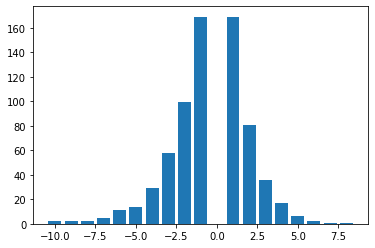

NYI


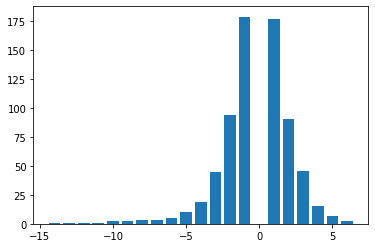

NYR


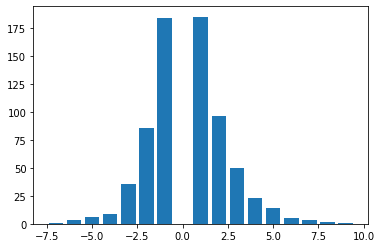

PHI


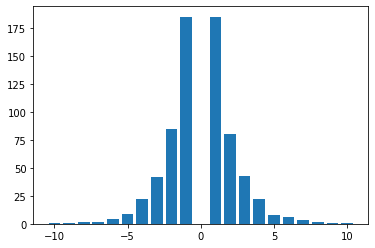

PIT


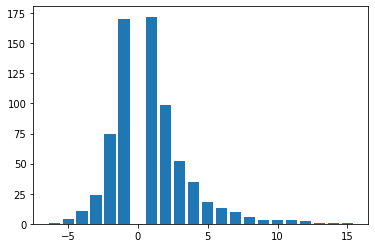

BOS


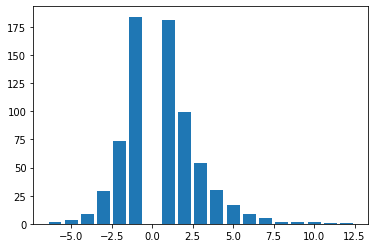

BUF


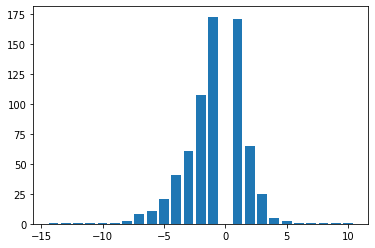

MTL


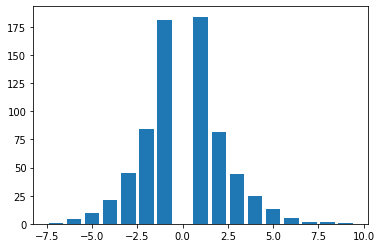

OTT


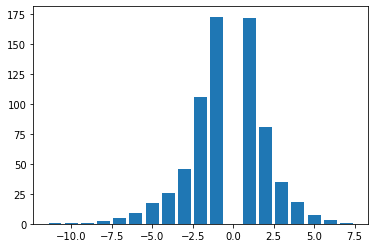

TOR


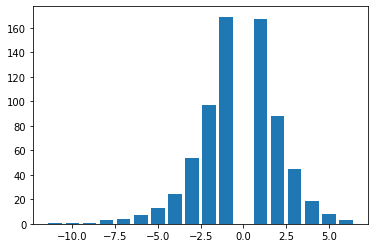

ATL


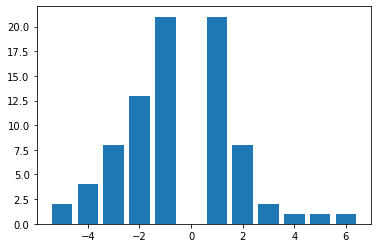

CAR


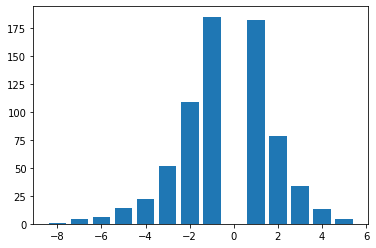

FLA


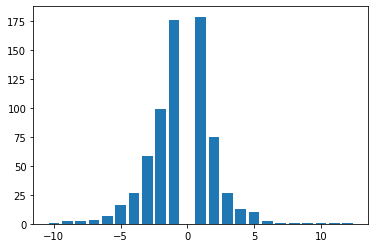

TBL


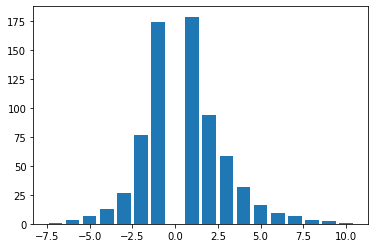

WSH


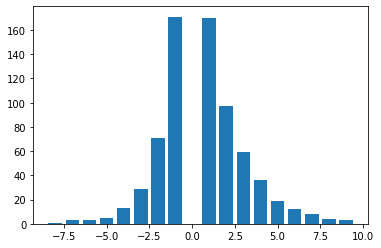

CHI


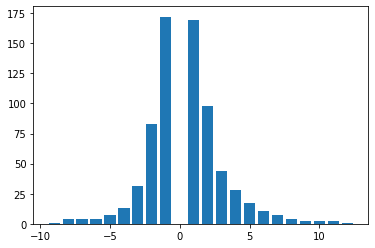

DET


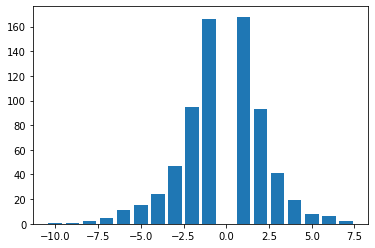

NSH


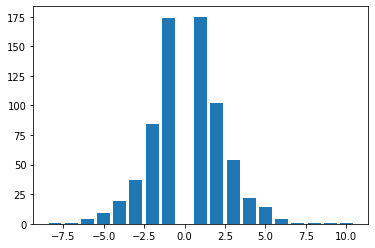

STL


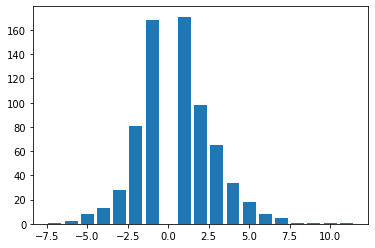

CGY


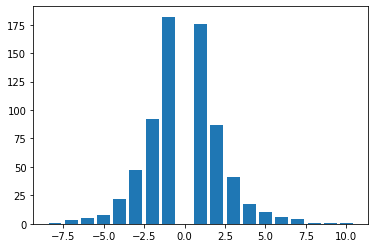

COL


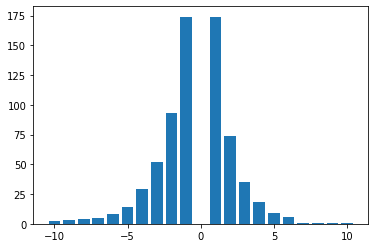

EDM


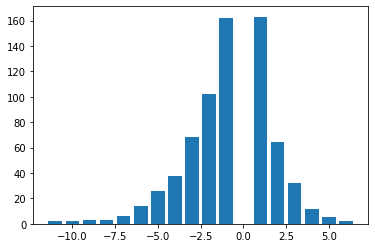

VAN


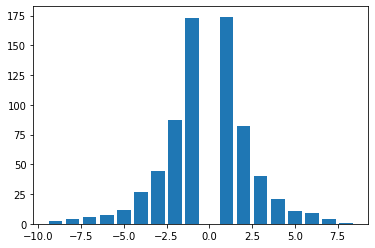

ANA


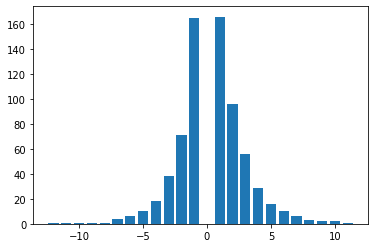

DAL


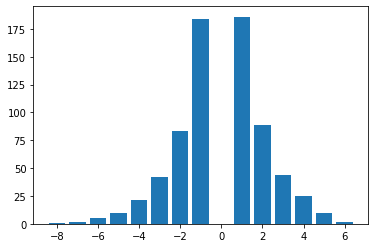

LAK


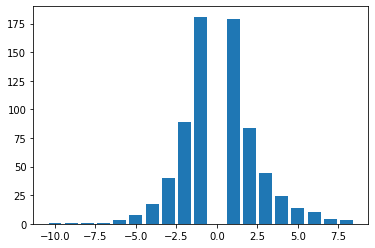

PHX


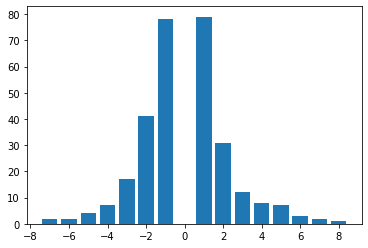

SJS


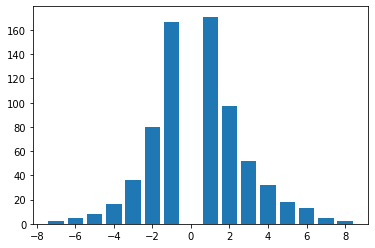

CBJ


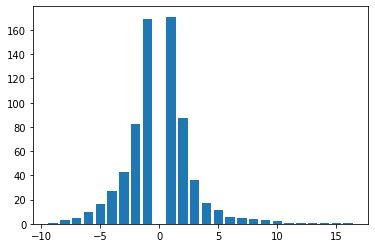

MIN


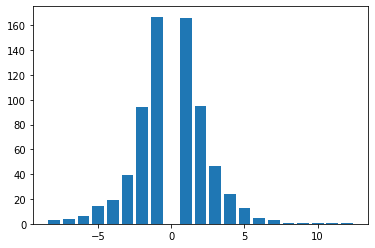

WPG


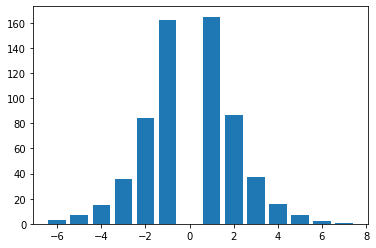

ARI


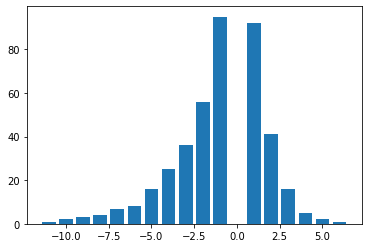

VGK


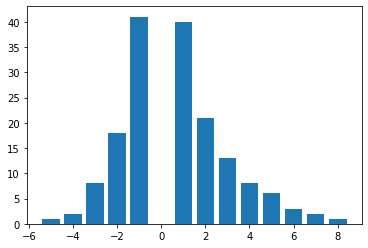

In [82]:
all_yrs_tms_dic = {}
for na in names_id_dict.keys():
    df8787 = pd.DataFrame()
    for i in teams87:
        name_year = i.split('-')
        if name_year[0]==na:
            df8787 = df8787.append(teams87.get(i))
    all_yrs_tms_dic.update({na:df8787})
for team in all_yrs_tms_dic:
    df = all_yrs_tms_dic.get(team)
    stks1 = list(df['streak'])
#     stks1 = list(stks1)
    stks = list(df['streak'].unique())
    teamdic={}
    for i in stks:
        teamdic.update({i:stks1.count(i)})
    print(team)
    fig,ax = plt.subplots()
    ax.bar(teamdic.keys(),teamdic.values())
    plt.show()

In [83]:
def get_counts_of_streaks(streak_length,lst):
    st_lens=[]
    cnts=[]
    if streak_length<0:
        for i in range(streak_length,min(lst)-1,-1):
            st_lens.append(i)
            cnts.append(lst.count(i))
    else:
        for i in range(streak_length,max(lst)+1):
            st_lens.append(i)
            cnts.append(lst.count(i))
    return st_lens,cnts

In [84]:
def point_diff_avg():
    for i in pts:
        team_year = pts.get(i)
        for j in team_year:
            if len(j)!=0:
                x = j[0]-j[1]
                diff.append(x)
    return sum(diff)/len(diff)
def get_point_diff_dict(pts):
    pts2={}
    for i in pts:
        diff=[]
        team_year = pts.get(i)
        for j in team_year:
            x = j[0]-j[1]
            diff.append([x,j[2]])
        pts2.update({i:diff})
    return pts2

In [85]:

strk_len = -3
dct,pts,lst = win_streak_per_team_per_season(teams2,strk_len,tm_pts,opp_points_dict)
strk_lens,cnts = get_counts_of_streaks(strk_len,lst)

In [86]:

years1 = {}
yr1 = int(yr)
for i in range(9):
    years1.update({yr1:{}})
    yr1+=1
yr_num_teams = {}
temp_yr = yr
# seasons = {}
for i in range(9):
    season2 = Season(nhl,(temp_yr+start))
#     seasons.update({years[i]:season2)
    num = len(season2.get_team_ids())
    yr_num_teams.update({temp_yr:num})
    temp_yr = str(int(temp_yr)+1)
pts2 = get_point_diff_dict(pts)  #pts 2=flattened pts
years = {}
for year in yr_num_teams:
    dic = {}
    for tm_yr in pts2:
        lst = tm_yr.split("-")
        if lst[1] == year:
            dic.update({tm_yr:(pts2.get(tm_yr))})
    years.update({year:dic})



TypeError: cum_pt_diff() missing 1 required positional argument: 'filename'

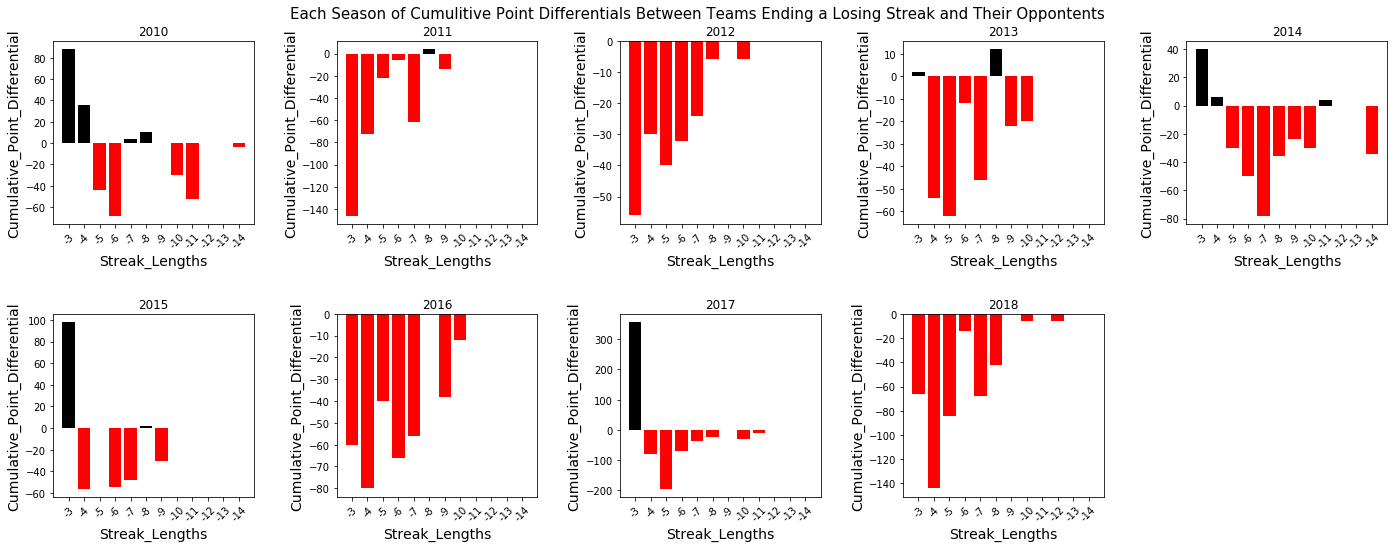

In [87]:

def years_tolist(some_years):
    lst57 =[]
    for i in some_years.keys():
        lst57.append(i)
    return lst57
def get_point_diffs_of_streaks2(sls,pt):
    d = {}
    for i in sls:
        d.update({i:0})
    for i in pt:
        team_year = pt.get(i)
        for x in team_year:
            if len(x)!=0:
                dif = x[0]
                d.update({x[1]:(d.get(x[1])+dif)})
    return d

# d = get_point_diffs_of_streaks2(strk_lens,years.get('2010'))
def cum_pt_diff(s,title,filename):
    strk_len = s
    dct,pts,lst = win_streak_per_team_per_season(teams2,strk_len,tm_pts,opp_points_dict)
    strk_lens,cnts = get_counts_of_streaks(strk_len,lst)
    years1 = {}
    yr1 = int(yr)
    for i in range(9):
        years1.update({yr1:{}})
        yr1+=1
    yr_num_teams = {}
    temp_yr = yr
    # seasons = {}
    for i in range(9):
        season2 = Season(nhl,(temp_yr+start))
    #     seasons.update({years[i]:season2)
        num = len(season2.get_team_ids())
        yr_num_teams.update({temp_yr:num})
        temp_yr = str(int(temp_yr)+1)
    pts2 = get_point_diff_dict(pts)  #pts 2=flattened pts
    years = {}
    for year in yr_num_teams:
        dic = {}
        for tm_yr in pts2:
            lst = tm_yr.split("-")
            if lst[1] == year:
                dic.update({tm_yr:(pts2.get(tm_yr))})
        years.update({year:dic})
    year_plot_prep = []
    for year in years:
        d = get_point_diffs_of_streaks2(strk_lens,years.get(year))
        data = pd.DataFrame.from_dict({'Streak_Lengths':d.keys(),'Cumulative_Point_Differential':d.values()},orient='index')
        data = data.T
        year_plot_prep.append(data)
    fig = plt.figure(figsize=(20,8))
    yrs = years_tolist(years)
    for i in range(len(year_plot_prep)):
        data = year_plot_prep[i]
        barheights = data.Cumulative_Point_Differential
        barlabels = data.Streak_Lengths
        ax = fig.add_subplot(2,5,i+1)
        ax.bar(range(len(barheights)), barheights, color=(barheights>0).map({True: 'black',False: 'r'}))
        ax.set_xticks(range(len(barheights)))
        ax.set_xticklabels(barlabels,rotation=45,fontsize=10)
        ax.set_ylabel('Cumulative_Point_Differential',fontsize=14)
        ax.set_xlabel('Streak_Lengths',fontsize=14)
    #     ax.text(x=.01,y=.01,s=yrs[i],color='g',ha='center',va='top',fontsize=17)
        ax.set_title(yrs[i])
    fig.tight_layout(pad=3)
    fig.suptitle(title,fontsize=15)
    fig.savefig(filename,dpi=125)
cum_pt_diff(-3,'Each Season of Cumulitive Point Differentials Between Teams Ending a Losing Streak and Their Oppontents','Cum_losing_streak_years.png')
cum_pt_diff(4,'Each Season of Cumulitive Point Differentials Between Teams Ending a Winning Streak and Their Oppontents''Cum_winning_streak_years.png')



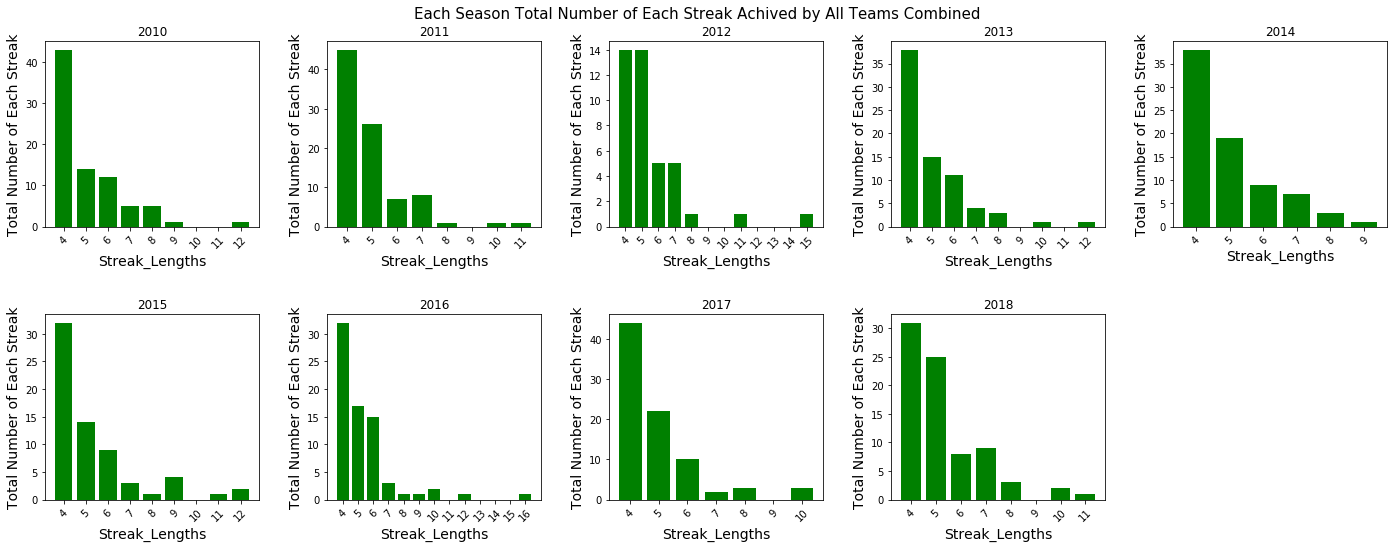

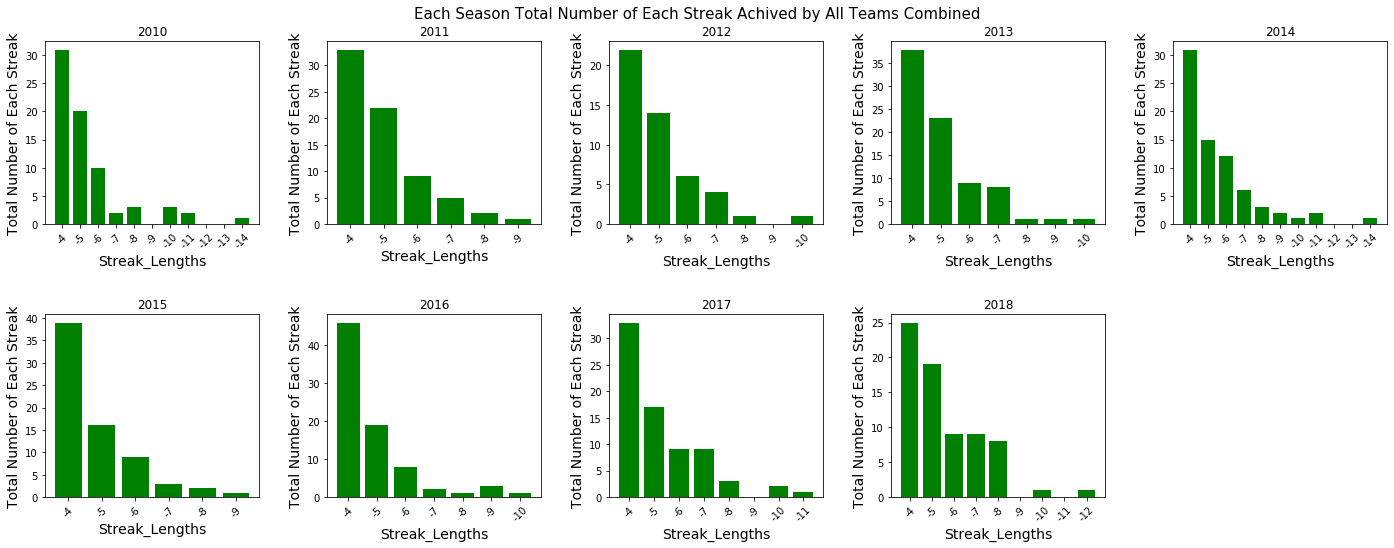

In [88]:
def season_streaks_plot(s,filename):
    strk_len = s
    year_totals ={}
    season = Season(nhl,'2010-09-30')
    years = []
    for i in season.end_reg_season:
        years.append(int(i)-1)
    for year in years:
        teams = data_form(nhl,str(year),'-09-30',stop_yr=int(year)+1) 
        dct,_,stk_lst = win_streak_per_team_per_season(teams,strk_len,tm_pts,opp_points_dict)#has external variables
        year_totals.update({year:get_counts_of_streaks(strk_len,stk_lst)})
    year_plot_prep = []
    for year in year_totals: 
        data = pd.DataFrame.from_dict({'Streak_Lengths':list(year_totals.get(year))[0],'Total_Number_of_Each_Streak':list(year_totals.get(year))[1]},orient='index')
        data = data.T
        year_plot_prep.append(data)
    fig = plt.figure(figsize=(20,8))
    yrs = years
    for i in range(len(year_plot_prep)):
        data = year_plot_prep[i]
        barheights = data.Total_Number_of_Each_Streak
        barlabels = data.Streak_Lengths
        ax = fig.add_subplot(2,5,i+1)
        ax.bar(range(len(barheights)), barheights, color=(barheights>0).map({True: 'g',False: 'r'}))
        ax.set_xticks(range(len(barheights)))
        ax.set_xticklabels(barlabels,rotation=45,fontsize=10)
        ax.set_ylabel('Total Number of Each Streak',fontsize=14)
        ax.set_xlabel('Streak_Lengths',fontsize=14)
    #     ax.text(x=.01,y=.01,s=yrs[i],color='g',ha='center',va='top',fontsize=17)
        ax.set_title(yrs[i])
    fig.tight_layout(pad=3)
    fig.suptitle('Each Season Total Number of Each Streak Achived by All Teams Combined',fontsize=15)
    fig.savefig(filename,dpi=125)
season_streaks_plot(4,'Season_Winning_Streak_Totals.png')
season_streaks_plot(-4,'Season_Losing_Streak_Totals.png')